Spoken Digit Recognition

In this notebook, You will do Spoken Digit Recognition. 

Input - speech signal, output - digit number

It contains  

1. Reading the dataset. and Preprocess the data set. Detailed instrctions are given below. You have to write the code in the same cell which contains the instrction. 
2. Training the LSTM with RAW data
3. Converting to spectrogram and Training the LSTM network
4. Creating the augmented data and doing step 2 and 3 again.  

Instructions:

1. Don't change any Grader Functions. Don't manipulate any Grader functions. If you manipulate any, it will be considered as plagiarised. 
2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
3. Please return outputs in the same format what we asked. Eg. Don't return List of we are asking for a numpy array.
4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
5. We are giving instructions at each section if necessary, please follow them.

In [1]:
!pip install patool --quiet

     |████████████████████████████████| 77 kB 3.3 MB/s 


In [2]:
!pip install tensorflow-addons --quiet

     |████████████████████████████████| 1.1 MB 4.4 MB/s 


In [3]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use(style='seaborn-deep')

In [4]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [5]:
from tqdm import tqdm

In [82]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import patoolib
import seaborn as sns

import librosa
import os
import time

In [7]:
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Dense,
    concatenate,
    GlobalAveragePooling1D,
    Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

We shared recordings.zip, please unzip those. 

In [9]:
# !gdown --id 1dpHrz4ldoPHAxkRXvQhqg72Mr1Gq1PSy

In [11]:
# patoolib.extract_archive(archive='/content/recordings.zip', outdir='/content/recordings')

In [12]:
recordings_path = '/content/recordings/recordings'
all_files = sorted(os.listdir(path=recordings_path))
print(all_files[:5])

['0_jackson_0.wav', '0_jackson_1.wav', '0_jackson_10.wav', '0_jackson_11.wav', '0_jackson_12.wav']


Grader function 1

In [13]:
def grader_files():
    temp = len(all_files) == 2000
    temp1 = all([x[-3:]=="wav" for x in all_files])
    temp = temp and temp1
    return temp

grader_files()

True

Create a dataframe (name=df_audio) with two columns(path, label). You can get the label from the first letter of name.

Example:

    0_jackson_0 --> 0  
    0_jackson_43 --> 0

In [14]:
def create_audio_dataframe(dir_path, files):
    """
    Creates the audio dataframe.
    """
    labels = [file.split('_')[0] for file in files]
    paths = [os.path.join(dir_path, file) for file in files]

    df = pd.DataFrame()
    df['path'] = paths
    df['label'] = labels
    return df

In [15]:
df_audio = create_audio_dataframe(dir_path=recordings_path, files=all_files)

In [16]:
df_audio.shape

(2000, 2)

In [17]:
df_audio.head()

,path,label
0,/content/recordings/recordings/0_jackson_0.wav,0
1,/content/recordings/recordings/0_jackson_1.wav,0
2,/content/recordings/recordings/0_jackson_10.wav,0
3,/content/recordings/recordings/0_jackson_11.wav,0
4,/content/recordings/recordings/0_jackson_12.wav,0


In [18]:
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


Exploring the sound dataset

In [19]:
import IPython

def play_audio(df, f_index):
    print(df['path'][df.index.to_list()[f_index]])
    return IPython.display.Audio(df['path'][df.index.to_list()[f_index]])

In [20]:
play_audio(df=df_audio, f_index=500)

/content/recordings/recordings/2_theo_0.wav


In [21]:
play_audio(df=df_audio, f_index=1000)

/content/recordings/recordings/5_jackson_0.wav


Grader function 2

In [22]:
def grader_df():
    flag_shape = df_audio.shape == (2000, 2)
    flag_columns = all(df_audio.columns == ['path', 'label'])
    list_values = list(df_audio.label.value_counts())
    flag_label = len(list_values) == 10
    flag_label2 = all([i == 200 for i in list_values])
    final_flag = flag_shape and flag_columns and flag_label and flag_label2
    return final_flag

grader_df()

True

In [23]:
df_audio = shuffle(df_audio, random_state=33)

Train and Validation split

In [24]:
X = df_audio['path']
y = df_audio['label']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45, stratify=y)

In [26]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1400,) (1400,)
(600,) (600,)


Grader function 3

In [27]:
def grader_split():
    flag_len = ((len(X_train) == 1400) and 
                (len(X_test) == 600) and 
                (len(y_train) == 1400) and 
                (len(y_test) == 600))
    values_ytrain = list(y_train.value_counts())
    flag_ytrain = (len(values_ytrain) == 10) and (all([i == 140 for i in values_ytrain]))
    values_ytest = list(y_test.value_counts())
    flag_ytest = (len(values_ytest) == 10) and (all([i == 60 for i in values_ytest]))
    final_flag = flag_len and flag_ytrain and flag_ytest
    return final_flag

grader_split()

True

Preprocessing

All files are in the "WAV" format. We will read those raw data files using the librosa.

In [28]:
def load_wav(x, get_duration=True):
    '''
    This return the array values of audio with sampling rate of 22050 and Duration
    '''
    # loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(samples, sr=sample_rate)
        return [samples, duration]
    else:
        return samples

In [43]:
samples, duration = load_wav(x=X_train[1394])
print(samples.shape)
print(duration)

(6103,)
0.27678004535147394


In [44]:
def create_preprocessed_audio_df(df):
    """
    Preprocesses the dataframe.
    """
    all_samples = []
    all_durations = []

    for i in tqdm(df.values):
        s, d = load_wav(x=i)
        all_samples.append(s)
        all_durations.append(d)
    
    df_preprocessed = pd.DataFrame()
    df_preprocessed['raw_data'] = all_samples
    df_preprocessed['duration'] = all_durations
    return df_preprocessed

In [45]:
X_train_processed = create_preprocessed_audio_df(df=X_train)
X_test_processed = create_preprocessed_audio_df(df=X_test)

100%|██████████| 600/600 [00:06<00:00, 95.37it/s]


In [46]:
X_train_processed.head()

,raw_data,duration
0,"[0.00011394074, 0.00012640332, 0.00012745972, ...",0.276780
1,"[0.015462314, 0.018172165, 0.01750962, 0.01515...",0.331519
2,"[0.0004158457, 0.00041390766, 7.270637e-05, -0...",0.292789
3,"[-0.00891809, -0.009839113, -0.009143287, -0.0...",0.344127
4,"[-0.009553918, -0.011437664, -0.011789859, -0....",0.659637


In [47]:
X_test_processed.head()

,raw_data,duration
0,"[0.00026219303, -3.563086e-05, -0.00013999043,...",0.314875
1,"[0.00032088827, -0.00014278508, -0.000590515, ...",0.515420
2,"[-0.00024847803, -0.00021077276, -0.0001466390...",0.269161
3,"[-0.004263563, -0.0033240004, -0.001765571, -0...",0.759274
4,"[0.00068556523, 0.0009813531, 0.0011631872, 0....",0.495646


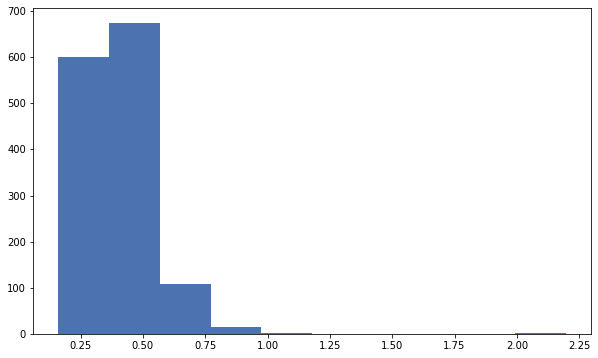

In [48]:
plt.figure(figsize=(10, 6))
plt.hist(X_train_processed['duration'])
plt.show()

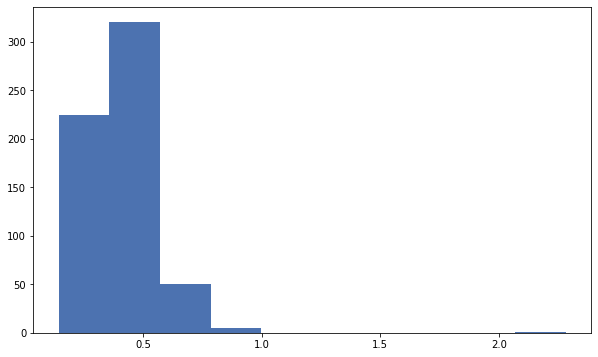

In [49]:
plt.figure(figsize=(10, 6))
plt.hist(X_test_processed['duration'])
plt.show()

Perceptile values from 0 to 100 with step size of 10 of duration from `X_train_processed data`.

In [50]:
for i in range(0, 101, 10):
    pt = np.percentile(a=X_train_processed['duration'], q=i)
    print('{}th percentile is : {}'.format(i, pt))

0th percentile is : 0.16104308390022676
10th percentile is : 0.25848072562358276
20th percentile is : 0.2974331065759637
30th percentile is : 0.3297777777777778
40th percentile is : 0.3569160997732426
50th percentile is : 0.38945578231292516
60th percentile is : 0.41328798185941046
70th percentile is : 0.4444671201814059
80th percentile is : 0.48268480725623586
90th percentile is : 0.5531655328798186
100th percentile is : 2.195918367346939


Perceptile values from 90 to 100 with step size of 1 of duration from `X_test_processed data`.

In [51]:
for i in range(90, 101, 1):
    pt = np.percentile(a=X_train_processed['duration'], q=i)
    print('{}th percentile is : {}'.format(i, pt))

90th percentile is : 0.5531655328798186
91th percentile is : 0.5669832199546486
92th percentile is : 0.5790349206349207
93th percentile is : 0.5995106575963719
94th percentile is : 0.611208163265306
95th percentile is : 0.6316009070294784
96th percentile is : 0.6431455782312925
97th percentile is : 0.6635741496598639
98th percentile is : 0.6957514739229022
99th percentile is : 0.79601179138322
100th percentile is : 2.195918367346939


Grader function 4

In [52]:
def grader_processed():
    flag_columns = ((all(X_train_processed.columns == ['raw_data', 'duration'])) and 
                    (all(X_test_processed.columns == ['raw_data', 'duration'])))
    flag_shape = (X_train_processed.shape == (1400, 2)) and (X_test_processed.shape == (600,2))
    return flag_columns and flag_shape

grader_processed()

True

- Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of `X_train_processed` and `X_test_processed` to 0.8 sec. It is similar to pad_sequence for a text dataset.
- While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640.
- Pad with Zero if length of sequence is less than 17640 else Truncate the number.
- Also create a masking vector for train and test.
- Masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.

In [53]:
max_length  = 17640

In [54]:
X_train_pad_seq = pad_sequences(sequences=X_train_processed['raw_data'].values, 
                                maxlen=max_length, 
                                padding='post', 
                                dtype='float32')
X_test_pad_seq = pad_sequences(sequences=X_test_processed['raw_data'].values, 
                               maxlen=max_length, 
                               padding='post', 
                               dtype='float32')

In [55]:
X_train_mask = np.where((X_train_pad_seq != 0), True, False)
X_test_mask = np.where((X_test_pad_seq != 0), True, False)

In [56]:
print(X_train_pad_seq.shape, X_test_pad_seq.shape)
print(X_train_mask.shape, X_test_mask.shape)

(1400, 17640) (600, 17640)
(1400, 17640) (600, 17640)


Grader function 5

In [59]:
def grader_padoutput():
    flag_padshape = ((X_train_pad_seq.shape == (1400, 17640)) and 
                     (X_test_pad_seq.shape == (600, 17640)) and 
                     (y_train.shape == (1400,)))
    flag_maskshape = ((X_train_mask.shape == (1400, 17640)) and 
                      (X_test_mask.shape == (600, 17640)) and 
                      (y_test.shape == (600,)))
    flag_dtype = (X_train_mask.dtype == bool) and (X_test_mask.dtype == bool)
    return flag_padshape and flag_maskshape and flag_dtype

grader_padoutput()

True

Performance plot

In [60]:
def plot_model_performance(tracker, epochs):
    plt.figure(figsize=(18, 6))

    plt.subplot(131)
    plt.plot(range(1, epochs+1), tracker.history['accuracy'], 'r--', label='train')
    plt.plot(range(1, epochs+1), tracker.history['val_accuracy'], 'g--', label='validation')
    plt.title('Accuracy Plot')
    plt.xlabel(xlabel='Epochs')
    plt.ylabel(ylabel='Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(132)
    plt.plot(range(1, epochs+1), tracker.history['loss'], 'r--', label='train')
    plt.plot(range(1, epochs+1), tracker.history['val_loss'], 'g--', label='validation')
    plt.title('Loss Plot')
    plt.xlabel(xlabel='Epochs')
    plt.ylabel(ylabel='Loss')
    plt.legend()
    plt.grid()

    plt.subplot(133)
    plt.plot(range(1, epochs+1), tracker.history['f1_score'], 'r--', label='train')
    plt.plot(range(1, epochs+1), tracker.history['val_f1_score'], 'g--', label='validation')
    plt.title('F1 Score Plot')
    plt.xlabel(xlabel='Epochs')
    plt.ylabel(ylabel='F1 Score')
    plt.legend()
    plt.grid()

    plt.show()

In [63]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

y_train_onehot = to_categorical(y=y_train, num_classes=10)
y_test_onehot = to_categorical(y=y_test, num_classes=10)

In [64]:
X_train_all = [X_train_pad_seq, X_train_mask]
X_test_all = [X_test_pad_seq, X_test_mask]

Model1: Giving Raw data directly.


Now we have

Train data: X_train_pad_seq, X_train_mask and y_train  
Test data: X_test_pad_seq, X_test_mask and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes `X_train_pad_seq` as input, `X_train_mask` as mask input. You can use any number of LSTM cells. Please read LSTM documentation(https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) in tensorflow to know more about mask and also https://www.tensorflow.org/guide/keras/masking_and_padding 
2. Get the final output of the LSTM and give it to Dense layer of any size and then give it to Dense layer of size 10(because we have 10 outputs) and then compile with the sparse categorical cross entropy( because we are not converting it to one hot vectors). Also check the datatype of class labels(y_values) and make sure that you convert your class labels  to integer datatype before fitting in the model.
3. While defining your model make sure that you pass both the input layer and mask input layer as input to lstm layer as follows
<img src='https://i.imgur.com/FvcgvbY.jpg'>
4. Use tensorboard to plot the graphs of loss and metric(use custom micro F1 score as metric) and histograms of gradients. You can write your code for computing F1 score using this <a  href='https://i.imgur.com/8YULUcu.jpg'>link</a>.
5. make sure that it won't overfit. 
6. You are free to include any regularization.


In [71]:
tf.keras.backend.clear_session()

input_pad = Input(shape=(max_length, 1), name='pad')
input_mask = Input(shape=(max_length, 1), name='mask')

concat = concatenate(inputs=[input_pad, input_mask], name='concat')

input_layer = [input_pad, input_mask]

lstm_layer = LSTM(units=32, name='lstm')(concat)
dense = Dense(units=50, activation='relu', name='dense')(lstm_layer)
output_layer = Dense(units=10, activation='softmax', name='output')(dense)

model_1 = Model(inputs=input_layer, outputs=output_layer, name='model_1')

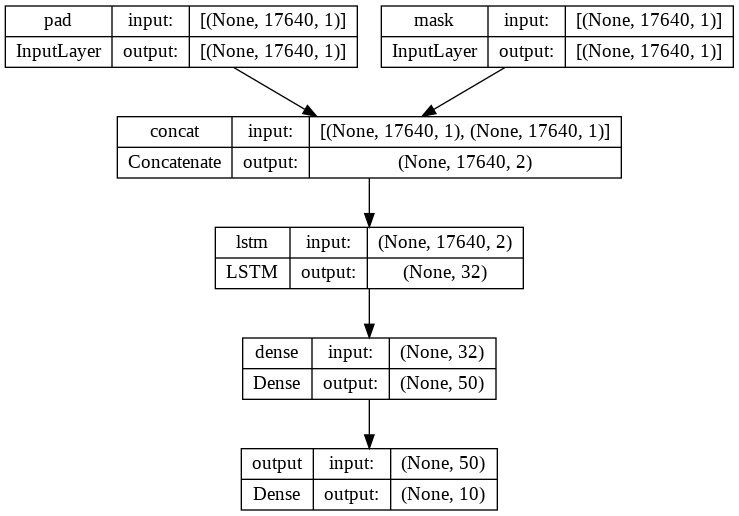

In [72]:
tf.keras.utils.plot_model(model=model_1,
                          to_file=os.path.join('/content/model_1.png'),
                          show_shapes=True, 
                          show_layer_names=True,
                          expand_nested=False,
                          dpi=96)

In [73]:
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pad (InputLayer)               [(None, 17640, 1)]   0           []                               
                                                                                                  
 mask (InputLayer)              [(None, 17640, 1)]   0           []                               
                                                                                                  
 concat (Concatenate)           (None, 17640, 2)     0           ['pad[0][0]',                    
                                                                  'mask[0][0]']                   
                                                                                                  
 lstm (LSTM)                    (None, 32)           4480        ['concat[0][0]']           

In [74]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.CategoricalCrossentropy(), 
                metrics=['accuracy', tfa.metrics.F1Score(num_classes=10, average='micro')])

In [75]:
epochs = 5
tracker_1 = model_1.fit(x=X_train_all, 
                        y=y_train_onehot, 
                        validation_data=(X_test_all, y_test_onehot), 
                        epochs=epochs, 
                        batch_size=100)

Epoch 1/5
14/14 [==============================] - 17s 716ms/step - loss: 2.3081 - accuracy: 0.0986 - f1_score: 0.1214 - val_loss: 2.2961 - val_accuracy: 0.1083 - val_f1_score: 0.1083
Epoch 2/5
14/14 [==============================] - 8s 585ms/step - loss: 2.2993 - accuracy: 0.0921 - f1_score: 0.0921 - val_loss: 2.2861 - val_accuracy: 0.1083 - val_f1_score: 0.1083
Epoch 3/5
14/14 [==============================] - 9s 668ms/step - loss: 2.2952 - accuracy: 0.1007 - f1_score: 0.1007 - val_loss: 2.2878 - val_accuracy: 0.1083 - val_f1_score: 0.1083
Epoch 4/5
14/14 [==============================] - 9s 618ms/step - loss: 2.2937 - accuracy: 0.0943 - f1_score: 0.0943 - val_loss: 2.2865 - val_accuracy: 0.1083 - val_f1_score: 0.1083
Epoch 5/5
14/14 [==============================] - 13s 980ms/step - loss: 2.2942 - accuracy: 0.0893 - f1_score: 0.0893 - val_loss: 2.2853 - val_accuracy: 0.1083 - val_f1_score: 0.1083


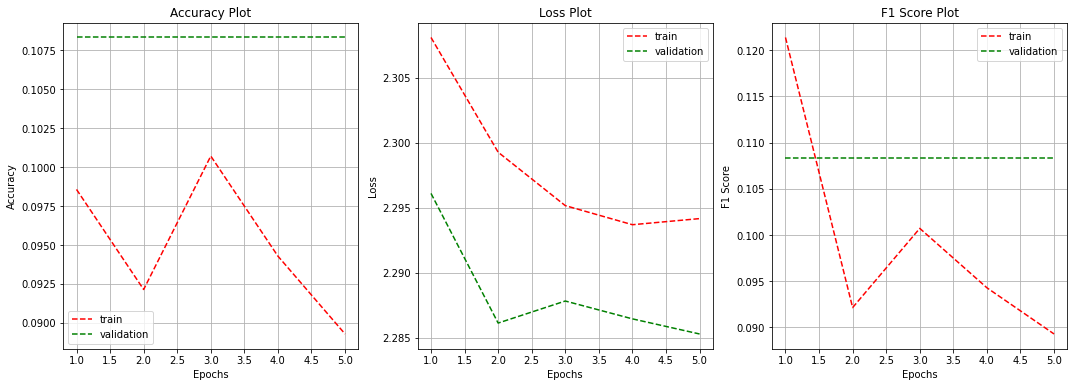

In [76]:
plot_model_performance(tracker=tracker_1, epochs=epochs)

Model2: Converting into spectrogram and giving spectrogram data as input

We can use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time i.e we are converting Time domain to frequency domain. you can read more about this in https://pnsn.org/spectrograms/what-is-a-spectrogram.

In [77]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [78]:
def make_spectrogram_matrix(pad_seq):
    spec = [convert_to_spectrogram(raw_data=i) for i in tqdm(pad_seq)]
    return np.array(spec)

In [80]:
X_train_spectrogram = make_spectrogram_matrix(pad_seq=X_train_pad_seq)
X_test_spectrogram = make_spectrogram_matrix(pad_seq=X_test_pad_seq)

100%|██████████| 600/600 [00:02<00:00, 238.22it/s]


In [81]:
print(X_train_spectrogram.shape, X_test_spectrogram.shape)

(1400, 64, 35) (600, 64, 35)


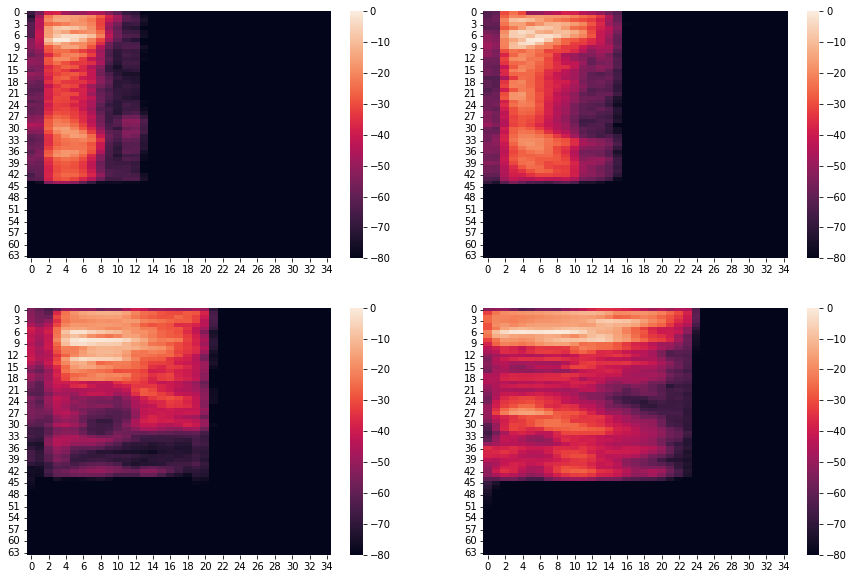

In [87]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
sns.heatmap(data=X_train_spectrogram[0])
plt.subplot(222)
sns.heatmap(data=X_train_spectrogram[100])
plt.subplot(223)
sns.heatmap(data=X_train_spectrogram[500])
plt.subplot(224)
sns.heatmap(data=X_train_spectrogram[1000])
plt.show()

Grader function 6

In [88]:
def grader_spectrogram():
    flag_shape = ((X_train_spectrogram.shape == (1400,64, 35)) and 
                  (X_test_spectrogram.shape == (600, 64, 35)))
    return flag_shape

grader_spectrogram()

True


Now we have

Train data: X_train_spectrogram and y_train  
Test data: X_test_spectrogram and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_spectrogram" as input and has to return output at every time step. 
2. Average the output of every time step and give this to the Dense layer of any size. 
(ex: Output from LSTM will be  (None, time_steps, features) average the output of every time step i.e, you should get (None,time_steps) 
and then pass to dense layer )
3. give the above output to Dense layer of size 10( output layer) and train the network with sparse categorical cross entropy.  
4. Use tensorboard to plot the graphs of loss and metric(use custom micro F1 score as metric) and histograms of gradients. You can write your code for computing F1 score using this <a  href='https://i.imgur.com/8YULUcu.jpg'>link</a> 
5. make sure that it won't overfit. 
6. You are free to include any regularization


In [89]:
tf.keras.backend.clear_session()

input_spec = Input(shape=X_train_spectrogram.shape[-2:], name='spec')
lstm_layer = LSTM(units=128, return_sequences=True, name='lstm')(input_spec)
lstm_layer = Dropout(rate=0.2, name='dropout')(lstm_layer)
avgpool = GlobalAveragePooling1D(name='avgpool')(lstm_layer)
dense = Dense(units=50, activation='relu', name='dense')(avgpool)
output_layer = Dense(units=10, activation='softmax', name='output')(dense)

model_2 = Model(inputs=input_spec, outputs=output_layer)

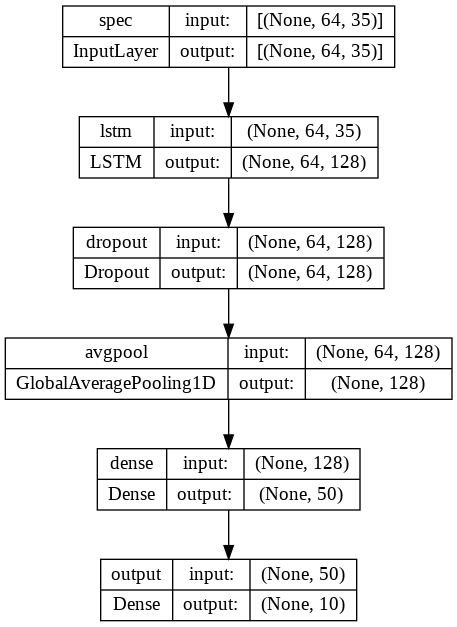

In [90]:
tf.keras.utils.plot_model(model=model_2,
                          to_file=os.path.join('/content/model_2.png'),
                          show_shapes=True, 
                          show_layer_names=True,
                          expand_nested=False,
                          dpi=96)

In [91]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spec (InputLayer)           [(None, 64, 35)]          0         
                                                                 
 lstm (LSTM)                 (None, 64, 128)           83968     
                                                                 
 dropout (Dropout)           (None, 64, 128)           0         
                                                                 
 avgpool (GlobalAveragePooli  (None, 128)              0         
 ng1D)                                                           
                                                                 
 dense (Dense)               (None, 50)                6450      
                                                                 
 output (Dense)              (None, 10)                510       
                                                             

In [92]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_2.compile(optimizer=optimizer, 
                loss=tf.keras.losses.CategoricalCrossentropy(), 
                metrics=['accuracy', tfa.metrics.F1Score(num_classes=10, average='micro')])

In [93]:
epochs = 60
tracker_2 = model_2.fit(x=X_train_spectrogram, 
                        y=y_train_onehot, 
                        validation_data=(X_test_spectrogram, y_test_onehot), 
                        epochs=epochs, 
                        batch_size=100)

Epoch 1/60
14/14 [==============================] - 2s 51ms/step - loss: 2.2203 - accuracy: 0.1829 - f1_score: 0.1829 - val_loss: 2.1528 - val_accuracy: 0.2383 - val_f1_score: 0.2383
Epoch 2/60
14/14 [==============================] - 0s 16ms/step - loss: 2.0894 - accuracy: 0.3029 - f1_score: 0.3029 - val_loss: 2.0415 - val_accuracy: 0.3133 - val_f1_score: 0.3133
Epoch 3/60
14/14 [==============================] - 0s 12ms/step - loss: 1.9818 - accuracy: 0.3386 - f1_score: 0.3386 - val_loss: 1.9685 - val_accuracy: 0.3567 - val_f1_score: 0.3567
Epoch 4/60
14/14 [==============================] - 0s 11ms/step - loss: 1.8795 - accuracy: 0.3750 - f1_score: 0.3750 - val_loss: 1.8427 - val_accuracy: 0.4333 - val_f1_score: 0.4333
Epoch 5/60
14/14 [==============================] - 0s 14ms/step - loss: 1.7760 - accuracy: 0.4357 - f1_score: 0.4357 - val_loss: 1.7361 - val_accuracy: 0.4267 - val_f1_score: 0.4267
Epoch 6/60
14/14 [==============================] - 0s 11ms/step - loss: 1.6638 - acc

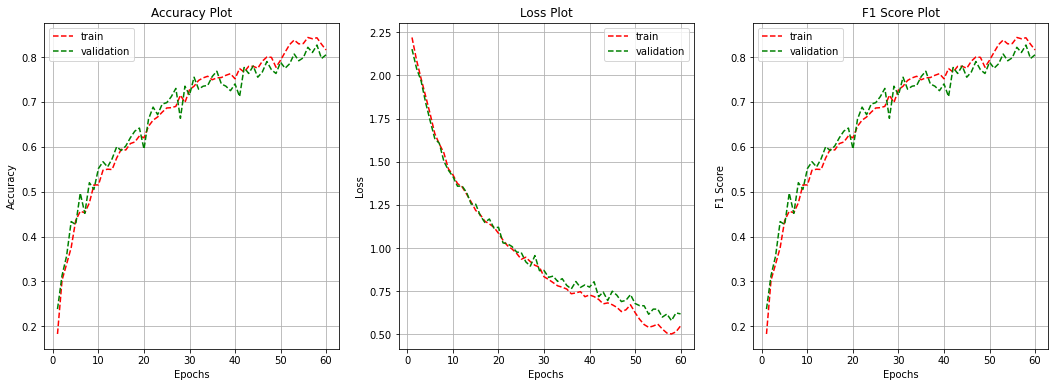

In [94]:
plot_model_performance(tracker=tracker_2, epochs=epochs)

Model3: Data augmentation with raw features

Till now we have done with 2000 samples only. It is very less data. We are giving the process of generating augmented data below.

There are two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower.
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.

In [95]:
def generate_augmented_data(file_path, sr=22050):
    augmented_data = []
    samples = load_wav(file_path, get_duration=False)

    for time_value in [0.7, 1, 1.3]:
    
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sr, n_steps=pitch_value)
            augmented_data.append(final_data)
    
    return augmented_data

In [96]:
temp_path = df_audio.iloc[0].path
aug_temp = generate_augmented_data(temp_path)

In [100]:
print(len(aug_temp))
print(len(aug_temp[0]))

9
10734


In [101]:
def perform_augmentation_on_train(X_train, y_train):
    x_aug = []
    y_aug = []

    for x_, y_ in zip(X_train.values, y_train.values):
        aug = generate_augmented_data(file_path=x_)

        for i in range(len(aug)):
            x_aug.append(aug[i])
            y_aug.append(y_)
    
    x_aug = np.array(x_aug)
    y_aug = np.array(y_aug)

    return x_aug, y_aug

In [102]:
X_train_augmented, y_train_augmented = perform_augmentation_on_train(X_train=X_train, y_train=y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


In [103]:
print(X_train_augmented.shape, y_train_augmented.shape)

(12600,) (12600,)


In [104]:
max_length = 17640
X_train_aug_pad_seq = pad_sequences(sequences=X_train_augmented, maxlen=max_length, padding='post', dtype='float32')
X_train_aug_mask = np.where((X_train_aug_pad_seq != 0), True, False)

In [105]:
y_train_aug_onehot = to_categorical(y=y_train_augmented, num_classes=10)

In [106]:
X_train_aug_all = [X_train_aug_pad_seq, X_train_aug_mask]

In [107]:
tf.keras.backend.clear_session()

input_pad = Input(shape=(max_length, 1), name='pad')
input_mask = Input(shape=(max_length, 1), name='mask')

concat = concatenate(inputs=[input_pad, input_mask], name='concat')

input_layer = [input_pad, input_mask]

lstm_layer = LSTM(units=32, name='lstm')(concat)
dense = Dense(units=50, activation='relu', name='dense')(lstm_layer)
output_layer = Dense(units=10, activation='softmax', name='output')(dense)

model_3 = Model(inputs=input_layer, outputs=output_layer, name='model_3')

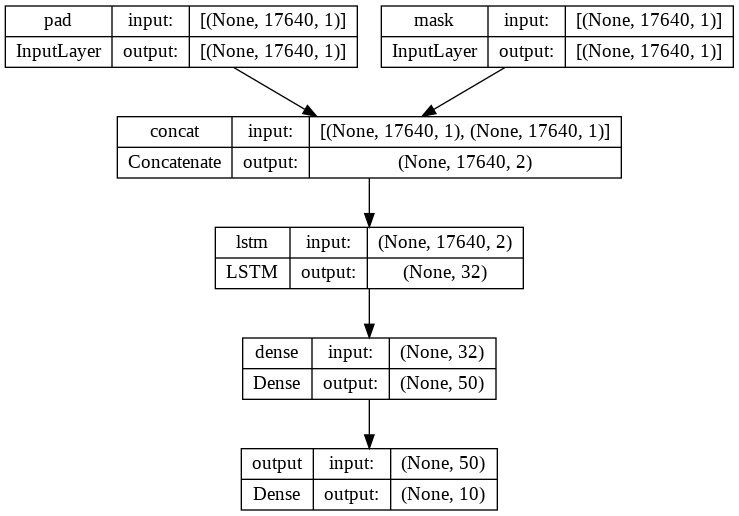

In [110]:
tf.keras.utils.plot_model(model=model_3,
                          to_file=os.path.join('/content/model_3.png'),
                          show_shapes=True, 
                          show_layer_names=True,
                          expand_nested=False,
                          dpi=96)

In [111]:
model_3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pad (InputLayer)               [(None, 17640, 1)]   0           []                               
                                                                                                  
 mask (InputLayer)              [(None, 17640, 1)]   0           []                               
                                                                                                  
 concat (Concatenate)           (None, 17640, 2)     0           ['pad[0][0]',                    
                                                                  'mask[0][0]']                   
                                                                                                  
 lstm (LSTM)                    (None, 32)           4480        ['concat[0][0]']           

In [108]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model_3.compile(optimizer=optimizer, 
                loss=tf.keras.losses.CategoricalCrossentropy(), 
                metrics=['accuracy', tfa.metrics.F1Score(num_classes=10, average='micro')])

In [109]:
epochs = 10
tracker_3 = model_3.fit(x=X_train_aug_all, 
                        y=y_train_aug_onehot, 
                        validation_data=(X_test_all, y_test_onehot), 
                        epochs=epochs, 
                        batch_size=100)

Epoch 1/10
126/126 [==============================] - 72s 560ms/step - loss: 2.3033 - accuracy: 0.1044 - f1_score: 0.1076 - val_loss: 2.2948 - val_accuracy: 0.1000 - val_f1_score: 0.1000
Epoch 2/10
126/126 [==============================] - 66s 524ms/step - loss: 2.2886 - accuracy: 0.1019 - f1_score: 0.1019 - val_loss: 2.2921 - val_accuracy: 0.1083 - val_f1_score: 0.1083
Epoch 3/10
126/126 [==============================] - 62s 493ms/step - loss: 2.2885 - accuracy: 0.1051 - f1_score: 0.1051 - val_loss: 2.2956 - val_accuracy: 0.1083 - val_f1_score: 0.1083
Epoch 4/10
126/126 [==============================] - 62s 493ms/step - loss: 2.2885 - accuracy: 0.1071 - f1_score: 0.1071 - val_loss: 2.2933 - val_accuracy: 0.1083 - val_f1_score: 0.1083
Epoch 5/10
126/126 [==============================] - 63s 497ms/step - loss: 2.2885 - accuracy: 0.1103 - f1_score: 0.1103 - val_loss: 2.2935 - val_accuracy: 0.1083 - val_f1_score: 0.1083
Epoch 6/10
126/126 [==============================] - 62s 491ms/s

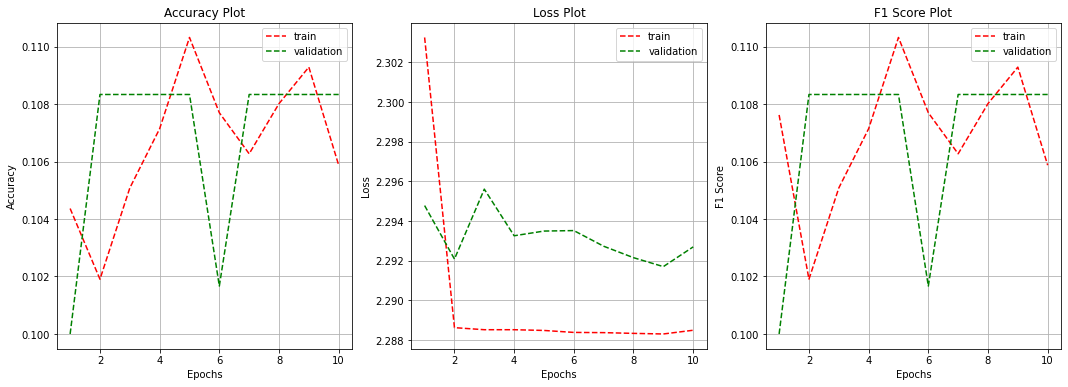

In [112]:
plot_model_performance(tracker=tracker_3, epochs=epochs)

Model4: Data augmentation with spectogram data

1. Use convert_to_spectrogram and convert the padded data from train and test data to spectogram data.
2. The shape of train data will be 14400 x 64 x 35 and shape of test_data will be 400 x 64 x35
3. Define the model similar to model 2 and fit the data.

In [114]:
X_train_aug_spectrogram = make_spectrogram_matrix(pad_seq=X_train_aug_pad_seq)

100%|██████████| 12600/12600 [00:58<00:00, 215.22it/s]


In [115]:
print(X_train_aug_spectrogram.shape)

(12600, 64, 35)


In [116]:
tf.keras.backend.clear_session()

input_spec = Input(shape=X_train_spectrogram.shape[-2:], name='spec')
lstm_layer = LSTM(units=128, return_sequences=True, name='lstm')(input_spec)
lstm_layer = Dropout(rate=0.2, name='dropout')(lstm_layer)
avgpool = GlobalAveragePooling1D(name='avgpool')(lstm_layer)
dense = Dense(units=50, activation='relu', name='dense')(avgpool)
output_layer = Dense(units=10, activation='softmax', name='output')(dense)

model_4 = Model(inputs=input_spec, outputs=output_layer)

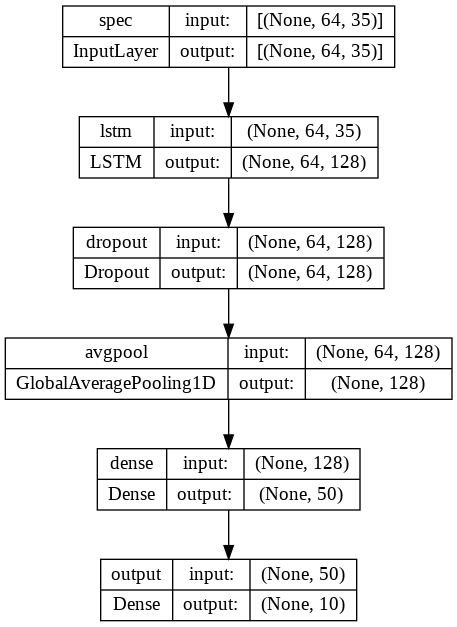

In [117]:
tf.keras.utils.plot_model(model=model_4,
                          to_file=os.path.join('/content/model_4.png'),
                          show_shapes=True, 
                          show_layer_names=True,
                          expand_nested=False,
                          dpi=96)

In [118]:
model_4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spec (InputLayer)           [(None, 64, 35)]          0         
                                                                 
 lstm (LSTM)                 (None, 64, 128)           83968     
                                                                 
 dropout (Dropout)           (None, 64, 128)           0         
                                                                 
 avgpool (GlobalAveragePooli  (None, 128)              0         
 ng1D)                                                           
                                                                 
 dense (Dense)               (None, 50)                6450      
                                                                 
 output (Dense)              (None, 10)                510       
                                                             

In [119]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_4.compile(optimizer=optimizer, 
                loss=tf.keras.losses.CategoricalCrossentropy(), 
                metrics=['accuracy', tfa.metrics.F1Score(num_classes=10, average='micro')])

In [121]:
epochs = 60
tracker_4 = model_4.fit(x=X_train_aug_spectrogram, 
                        y=y_train_aug_onehot, 
                        validation_data=(X_test_spectrogram, y_test_onehot), 
                        epochs=epochs, 
                        batch_size=100)

Epoch 1/60
126/126 [==============================] - 3s 14ms/step - loss: 2.0925 - accuracy: 0.2490 - f1_score: 0.2490 - val_loss: 1.8343 - val_accuracy: 0.4317 - val_f1_score: 0.4317
Epoch 2/60
126/126 [==============================] - 1s 9ms/step - loss: 1.7254 - accuracy: 0.3998 - f1_score: 0.3998 - val_loss: 1.4662 - val_accuracy: 0.5200 - val_f1_score: 0.5200
Epoch 3/60
126/126 [==============================] - 1s 9ms/step - loss: 1.4539 - accuracy: 0.5010 - f1_score: 0.5010 - val_loss: 1.3338 - val_accuracy: 0.5150 - val_f1_score: 0.5150
Epoch 4/60
126/126 [==============================] - 1s 9ms/step - loss: 1.3037 - accuracy: 0.5579 - f1_score: 0.5579 - val_loss: 1.1266 - val_accuracy: 0.6083 - val_f1_score: 0.6083
Epoch 5/60
126/126 [==============================] - 1s 9ms/step - loss: 1.1924 - accuracy: 0.5923 - f1_score: 0.5923 - val_loss: 1.0630 - val_accuracy: 0.6700 - val_f1_score: 0.6700
Epoch 6/60
126/126 [==============================] - 1s 9ms/step - loss: 1.097

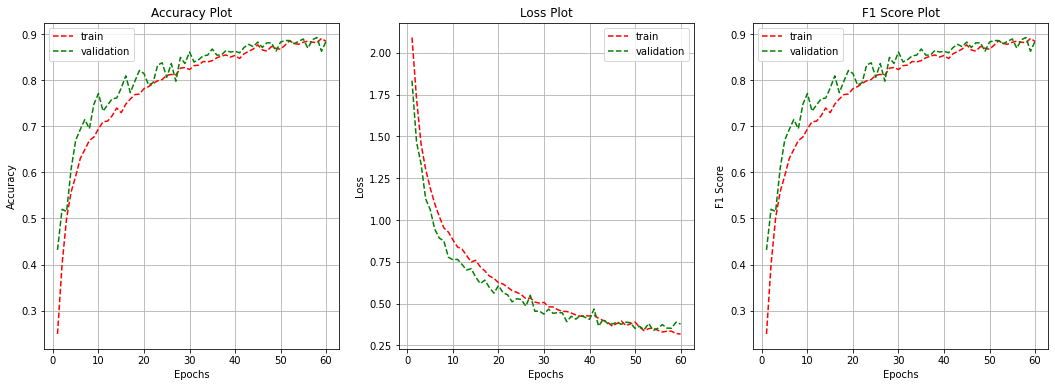

In [122]:
plot_model_performance(tracker=tracker_4, epochs=epochs)

Conclusion:

![](https://i.imgur.com/6bbLyjE.jpeg)

Model1, Model3 have poor `f1_score` but Model2, Model4 have good `f1_score`.